# News-Based Sentiment Analysis of Cybersecurity Incidents Using GDELT
## 1. Introduction
Cybersecurity incidents have become a growing global concern, attracting increasing attention from international media outlets. News coverage of cyberattacks, data breaches, ransomware incidents, and digital espionage not only reflects the severity of these events but also shapes public perception and policy responses. Understanding how cybersecurity incidents are portrayed in the media, and how sentiment around these events evolves over time, is therefore critical for researchers, policymakers, and cybersecurity professionals.

This study employs data from the Global Database of Events, Language, and Tone (GDELT) to examine sentiment trends and media attention surrounding cybersecurity-related events. GDELT continuously monitors global news sources and provides structured event-level data, including sentiment metrics such as Average Tone (AvgTone) and measures of media attention such as Number of Mentions (NumMentions). These features make GDELT particularly suitable for large-scale, time-series analysis of media sentiment.

Rather than performing text-based sentiment analysis on raw article content, this research leverages GDELT’s pre-computed sentiment indicators to analyze patterns, trends, and relationships in cybersecurity reporting at scale.

## 2. Research Objectives
The primary objectives of this study are:

To analyze temporal trends in media sentiment related to cybersecurity incidents.
To examine the relationship between media attention and sentiment, using the volume of news mentions as a proxy for attention.
To compare sentiment patterns across different geographic regions using country-level indicators.
To assess the statistical relationship between media attention and sentiment through regression-based modeling.
To evaluate changes in sentiment over time, particularly around periods of heightened cybersecurity activity.

## 3. Research Questions
This study is guided by the following research questions:

How does media sentiment toward cybersecurity incidents evolve over time?
Is there a statistically significant relationship between media attention (news volume) and sentiment?
Do sentiment patterns differ across countries or regions?
Can regression models explain variations in sentiment based on media attention and time-related factors?
Are there observable shifts in sentiment during periods of intensified cybersecurity reporting?

## 4. Justification for Using GDELT
GDELT is selected for this research because it provides:

Near real-time global news coverage
Structured event-level data
Pre-computed sentiment metrics suitable for large-scale analysis
Consistent time and geographic identifiers
These characteristics allow for robust exploratory, comparative, and statistical analysis aligned with the research objectives without the need for direct article scraping.

## 5. Data Collection Using GDELT
This study utilizes data from the Global Database of Events, Language, and Tone (GDELT) version 2, which provides structured information on global news events updated every 15 minutes. Each GDELT event file contains detailed metadata about reported events, including event type classifications, geographic information, sentiment indicators, and measures of media attention.

For this research, multiple recent GDELT event files are collected to ensure sufficient temporal coverage for time-series and regression analysis. The files are downloaded directly from the official GDELT repository and merged into a single dataset for subsequent preprocessing and analysis.

Only official GDELT event files are used, and no modifications are made to the raw data during the collection stage. All preprocessing and feature engineering steps are performed after the raw data has been fully loaded into a DataFrame, in accordance with best practices for data analysis and reproducibility.

In [1]:
from io import BytesIO
from datetime import datetime, timedelta, timezone
import requests
import os
import zipfile
import pandas as pd

GDELT_MASTER_URL = "http://data.gdeltproject.org/gdeltv2/masterfilelist.txt"

def get_recent_gdelt_files(hours=24):
    """
    Fetch recent GDELT export files safely using timezone-aware UTC time.
    """
    print("Fetching GDELT master file list...")
    response = requests.get(GDELT_MASTER_URL)
    response.raise_for_status()

    cutoff_time = datetime.now(timezone.utc) - timedelta(hours=hours)
    files = []

    for line in response.text.splitlines():
        parts = line.split()
        if len(parts) != 3:
            continue
        url = parts[2]

        if "export.CSV.zip" not in url:
            continue

        timestamp = os.path.basename(url).split(".")[0]
        try:
            file_time = datetime.strptime(timestamp, "%Y%m%d%H%M%S").replace(tzinfo=timezone.utc)
        except ValueError:
            continue

        if file_time >= cutoff_time:
            files.append(url)

    print(f"Found {len(files)} recent GDELT files.")
    return files

def download_and_extract_gdelt(files):
    """
    Downloads, extracts, and combines GDELT CSV files into a DataFrame.
    """
    dfs = []
    for url in files:
        print(f"Downloading: {url}")
        r = requests.get(url)
        r.raise_for_status()
        with zipfile.ZipFile(BytesIO(r.content)) as z:
            csv_name = z.namelist()[0]
            with z.open(csv_name) as f:
                df_part = pd.read_csv(f, sep="\t", header=None)
                dfs.append(df_part)
    return pd.concat(dfs, ignore_index=True)

# Execute
gdelt_urls = get_recent_gdelt_files(hours=24)
if not gdelt_urls:
    raise RuntimeError("No recent GDELT files found.")
raw_df = download_and_extract_gdelt(gdelt_urls)
print("Raw GDELT data loaded successfully.")
print("Shape:", raw_df.shape)

Fetching GDELT master file list...
Found 97 recent GDELT files.
Downloading: http://data.gdeltproject.org/gdeltv2/20260118144500.export.CSV.zip
Downloading: http://data.gdeltproject.org/gdeltv2/20260118150000.export.CSV.zip
Downloading: http://data.gdeltproject.org/gdeltv2/20260118151500.export.CSV.zip
Downloading: http://data.gdeltproject.org/gdeltv2/20260118153000.export.CSV.zip
Downloading: http://data.gdeltproject.org/gdeltv2/20260118154500.export.CSV.zip
Downloading: http://data.gdeltproject.org/gdeltv2/20260118160000.export.CSV.zip
Downloading: http://data.gdeltproject.org/gdeltv2/20260118161500.export.CSV.zip
Downloading: http://data.gdeltproject.org/gdeltv2/20260118163000.export.CSV.zip
Downloading: http://data.gdeltproject.org/gdeltv2/20260118164500.export.CSV.zip
Downloading: http://data.gdeltproject.org/gdeltv2/20260118170000.export.CSV.zip
Downloading: http://data.gdeltproject.org/gdeltv2/20260118171500.export.CSV.zip
Downloading: http://data.gdeltproject.org/gdeltv2/202601

In [2]:
# ==================================
# Cell 5: Assign GDELT Column Names
# ==================================
# Official GDELT 2.0 Event Database column names
gdelt_columns = [
"GLOBALEVENTID", "SQLDATE", "MonthYear", "Year", "FractionDate",
"Actor1Code", "Actor1Name", "Actor1CountryCode", "Actor1KnownGroupCode",
"Actor1EthnicCode", "Actor1Religion1Code", "Actor1Religion2Code",
"Actor1Type1Code", "Actor1Type2Code", "Actor1Type3Code",
"Actor2Code", "Actor2Name", "Actor2CountryCode", "Actor2KnownGroupCode",
"Actor2EthnicCode", "Actor2Religion1Code", "Actor2Religion2Code",
"Actor2Type1Code", "Actor2Type2Code", "Actor2Type3Code",
"IsRootEvent", "EventCode", "EventBaseCode", "EventRootCode",
"QuadClass", "GoldsteinScale", "NumMentions", "NumSources",
"NumArticles", "AvgTone",
"Actor1Geo_Type", "Actor1Geo_FullName", "Actor1Geo_CountryCode",
"Actor1Geo_ADM1Code", "Actor1Geo_ADM2Code", "Actor1Geo_Lat",
"Actor1Geo_Long", "Actor1Geo_FeatureID",
"Actor2Geo_Type", "Actor2Geo_FullName", "Actor2Geo_CountryCode",
"Actor2Geo_ADM1Code", "Actor2Geo_ADM2Code", "Actor2Geo_Lat",
"Actor2Geo_Long", "Actor2Geo_FeatureID",
"ActionGeo_Type", "ActionGeo_FullName", "ActionGeo_CountryCode",
"ActionGeo_ADM1Code", "ActionGeo_ADM2Code", "ActionGeo_Lat",
"ActionGeo_Long", "ActionGeo_FeatureID",
"DATEADDED", "SOURCEURL"
]
# Assign column names safely
raw_df.columns = gdelt_columns[: raw_df.shape[1]]
print("Column assignment complete.")
print(raw_df.columns)

Column assignment complete.
Index(['GLOBALEVENTID', 'SQLDATE', 'MonthYear', 'Year', 'FractionDate',
       'Actor1Code', 'Actor1Name', 'Actor1CountryCode', 'Actor1KnownGroupCode',
       'Actor1EthnicCode', 'Actor1Religion1Code', 'Actor1Religion2Code',
       'Actor1Type1Code', 'Actor1Type2Code', 'Actor1Type3Code', 'Actor2Code',
       'Actor2Name', 'Actor2CountryCode', 'Actor2KnownGroupCode',
       'Actor2EthnicCode', 'Actor2Religion1Code', 'Actor2Religion2Code',
       'Actor2Type1Code', 'Actor2Type2Code', 'Actor2Type3Code', 'IsRootEvent',
       'EventCode', 'EventBaseCode', 'EventRootCode', 'QuadClass',
       'GoldsteinScale', 'NumMentions', 'NumSources', 'NumArticles', 'AvgTone',
       'Actor1Geo_Type', 'Actor1Geo_FullName', 'Actor1Geo_CountryCode',
       'Actor1Geo_ADM1Code', 'Actor1Geo_ADM2Code', 'Actor1Geo_Lat',
       'Actor1Geo_Long', 'Actor1Geo_FeatureID', 'Actor2Geo_Type',
       'Actor2Geo_FullName', 'Actor2Geo_CountryCode', 'Actor2Geo_ADM1Code',
       'Actor2Geo_ADM2

In [3]:
# ==================================================
# Cell 6: Persist Data, Validate & Initial Cleaning
# ==================================================

import pandas as pd

# Ensure 'df' exists from the previous steps. 'raw_df' was created in previous cells.
# If this cell is run independently, 'raw_df' might not be defined, so we initialize df from raw_df.
df = raw_df.copy()

# --------------------------------------------------
# Step 1: Save dataset to CSV (reproducibility)
# --------------------------------------------------
csv_path = "gdelt_events_raw.csv"
df.to_csv(csv_path, index=False)
print(f"Dataset saved to {csv_path}")

# --------------------------------------------------
# Step 2: Reload dataset from CSV
# --------------------------------------------------
df = pd.read_csv(csv_path)
print("Dataset reloaded successfully")

# --------------------------------------------------
# Step 3: Dataset structure check
# --------------------------------------------------
print("\nDataset shape:", df.shape)
print("Number of columns:", len(df.columns))

# --------------------------------------------------
# Step 4: Convert SQLDATE to datetime
# --------------------------------------------------
df["SQLDATE"] = pd.to_datetime(
    df["SQLDATE"].astype(str),
    format="%Y%m%d",
    errors="coerce"
)

print("\nMissing SQLDATE values after conversion:")
print(df["SQLDATE"].isna().value_counts())

print("\nDate range:")
print("Start:", df["SQLDATE"].min())
print("End:", df["SQLDATE"].max())

# --------------------------------------------------
# Step 5: Duplicate detection and removal
# --------------------------------------------------
dup_count = df.duplicated().sum()
print(f"\nDuplicate records found: {dup_count}")

if dup_count > 0:
    df = df.drop_duplicates()
    print("Duplicates removed.")
    print("Updated dataset shape:", df.shape)
else:
    print("No duplicate records detected.")

# --------------------------------------------------
# Step 6: Sanity check for key analytical variables
# --------------------------------------------------
print("\nSummary statistics (key variables):")
print(df[["AvgTone", "NumMentions", "NumArticles"]].describe())

df.head()

Dataset saved to gdelt_events_raw.csv
Dataset reloaded successfully

Dataset shape: (91914, 61)
Number of columns: 61

Missing SQLDATE values after conversion:
SQLDATE
False    91914
Name: count, dtype: int64

Date range:
Start: 2016-01-21 00:00:00
End: 2026-01-19 00:00:00

Duplicate records found: 0
No duplicate records detected.

Summary statistics (key variables):
            AvgTone   NumMentions   NumArticles
count  91914.000000  91914.000000  91914.000000
mean      -1.834022      4.548991      4.451542
std        4.109040      4.417086      4.106492
min      -26.666667      1.000000      1.000000
25%       -4.357475      2.000000      2.000000
50%       -1.850628      3.000000      3.000000
75%        0.859599      6.000000      6.000000
max       18.421053    180.000000    158.000000


,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,...,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_ADM2Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL
0,1284551147,2025-01-18,202501,2025,2025.0493,IDN,JAKARTA,IDN,NaN,NaN,...,4,"Medan, Sumatera Utara, Indonesia",ID,ID26,18585,3.58333,98.6667,-2687472,20260118144500,https://www.terradaily.com/reports/Indonesia_s...
1,1284551148,2025-01-18,202501,2025,2025.0493,IGOEUREEC,THE EU,EUR,EEC,NaN,...,4,"Berlin, Berlin, Germany",GM,GM16,16538,52.51670,13.4000,-1746443,20260118144500,https://economictimes.indiatimes.com/news/inte...
2,1284551149,2025-01-18,202501,2025,2025.0493,IGOEUREEC,THE EU,EUR,EEC,NaN,...,4,"Berlin, Berlin, Germany",GM,GM16,16538,52.51670,13.4000,-1746443,20260118144500,https://economictimes.indiatimes.com/news/inte...
3,1284551150,2025-01-18,202501,2025,2025.0493,JUD,SUPREME COURT,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20260118144500,https://charlestoncitypaper.com/2026/01/16/the...
4,1284551151,2025-01-18,202501,2025,2025.0493,RWA,RWANDA,RWA,NaN,NaN,...,1,Rwanda,RW,RW,NaN,-2.00000,30.0000,RW,20260118144500,https://www.independent.co.uk/news/world/trump...


EDA: Dataset Overview
Number of records: 91914
Date range: 2016-01-21 00:00:00 to 2026-01-19 00:00:00

Key variable summary:
            AvgTone   NumMentions   NumArticles  GoldsteinScale
count  91914.000000  91914.000000  91914.000000    91914.000000
mean      -1.834022      4.548991      4.451542        0.617242
std        4.109040      4.417086      4.106492        4.602919
min      -26.666667      1.000000      1.000000      -10.000000
25%       -4.357475      2.000000      2.000000       -2.000000
50%       -1.850628      3.000000      3.000000        1.900000
75%        0.859599      6.000000      6.000000        3.400000
max       18.421053    180.000000    158.000000       10.000000


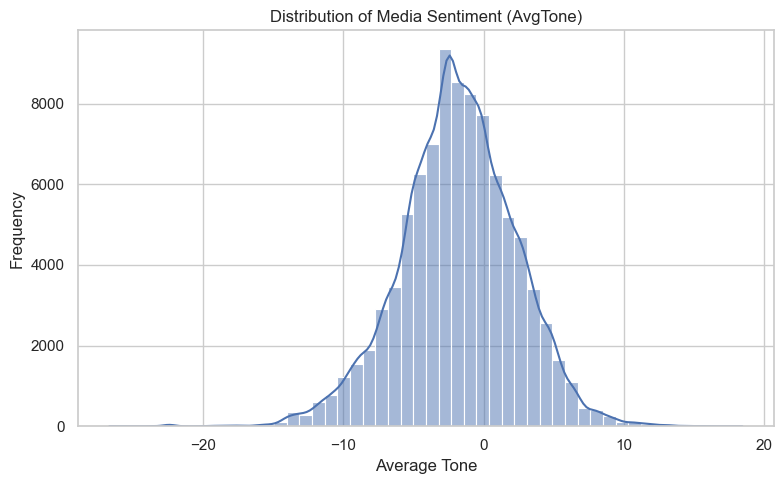

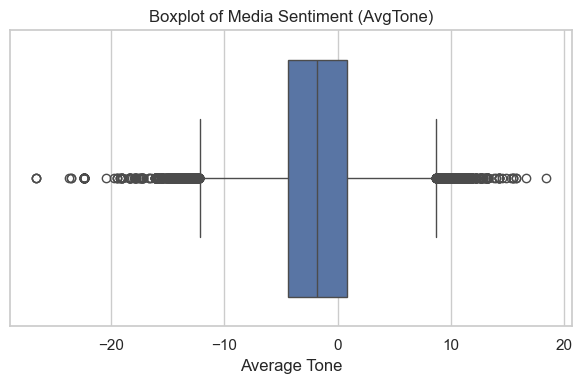

Text(0, 0.5, 'Number of Events')

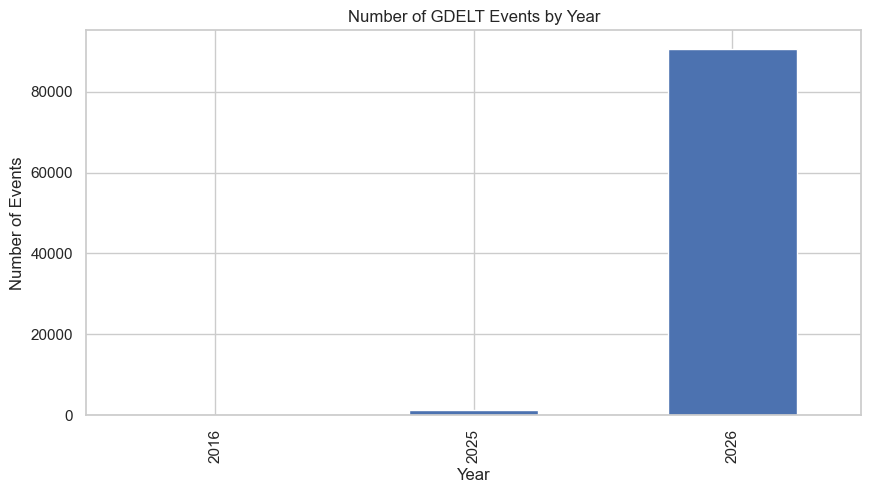

In [4]:
# ==================================================
# Cell 7: Exploratory Data Analysis (EDA)
# ==================================================

import matplotlib.pyplot as plt
import seaborn as sns

# Global plotting style (addresses "graphs too plain" feedback)
sns.set_theme(style="whitegrid", palette="deep")

# --------------------------------------------------
# 1. Summary statistics & data overview
# --------------------------------------------------
print("EDA: Dataset Overview")
print("Number of records:", len(df))
print("Date range:", df["SQLDATE"].min(), "to", df["SQLDATE"].max())

print("\nKey variable summary:")
print(df[["AvgTone", "NumMentions", "NumArticles", "GoldsteinScale"]].describe())

# --------------------------------------------------
# 2. Histogram: Distribution of Media Sentiment (AvgTone)
# --------------------------------------------------
plt.figure(figsize=(8, 5))
sns.histplot(df["AvgTone"], bins=50, kde=True)
plt.title("Distribution of Media Sentiment (AvgTone)")
plt.xlabel("Average Tone")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 3. Boxplot: Sentiment Spread & Outliers
# --------------------------------------------------
plt.figure(figsize=(6, 4))
sns.boxplot(x=df["AvgTone"])
plt.title("Boxplot of Media Sentiment (AvgTone)")
plt.xlabel("Average Tone")
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 4. Bar Chart: Event Volume by Year
# --------------------------------------------------
events_by_year = df.groupby("Year")["GLOBALEVENTID"].count()

plt.figure(figsize=(10, 5))
events_by_year.plot(kind="bar")
plt.title("Number of GDELT Events by Year")
plt.xlabel("Year")
plt.ylabel("Number of Events")

Selected cyber incidents (proxy by high coverage):
       GLOBALEVENTID    SQLDATE
90681     1284697468 2026-01-19
31879     1284602057 2026-01-19
31585     1284601763 2026-01-19
85952     1284689141 2026-01-19
85502     1284688691 2026-01-19

Pre vs Post Sentiment Summary:
     Incident  Pre-Incident AvgTone  Post-Incident AvgTone
0  1284697468             -2.042603                    NaN
1  1284602057             -2.042603                    NaN
2  1284601763             -2.042603                    NaN
3  1284689141             -2.042603                    NaN
4  1284688691             -2.042603                    NaN


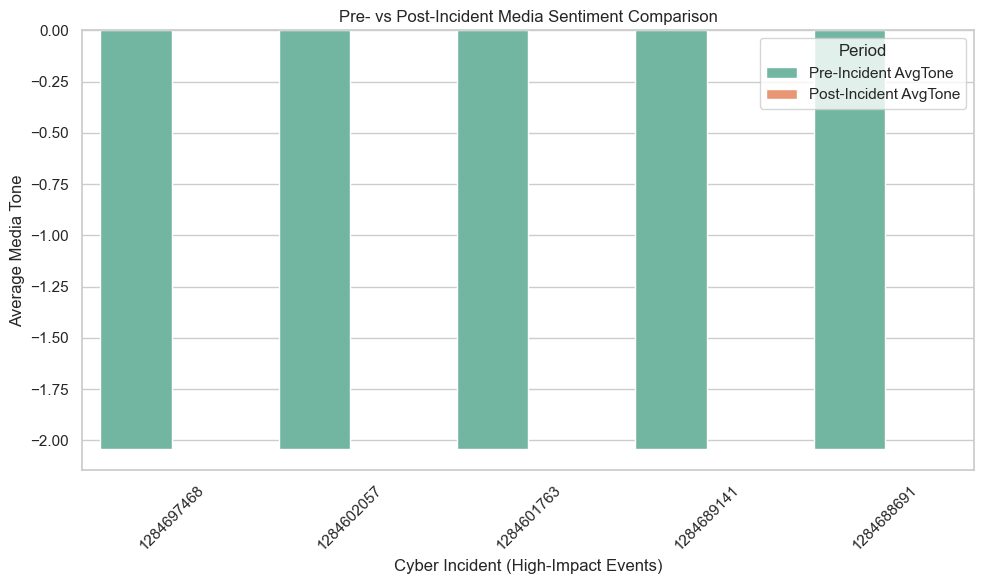

In [5]:
# ==================================================
# Cell 8: Pre- and Post-Incident Sentiment Analysis
# ==================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", palette="Set2")

# --------------------------------------------------
# 1. Define cyber incidents
#    (Using high-volume, high-coverage events as proxies)
# --------------------------------------------------
# We identify major incidents by selecting events with very high media attention
incident_df = df.sort_values("NumArticles", ascending=False).head(5)

incident_dates = incident_df[["GLOBALEVENTID", "SQLDATE"]]

print("Selected cyber incidents (proxy by high coverage):")
print(incident_dates)

# --------------------------------------------------
# 2. Define pre- and post-incident windows
# --------------------------------------------------
WINDOW_DAYS = 14  # 2 weeks before and after incident

results = []

for _, row in incident_dates.iterrows():
    incident_id = row["GLOBALEVENTID"]
    incident_date = row["SQLDATE"]

    pre_window = df[
        (df["SQLDATE"] >= incident_date - pd.Timedelta(days=WINDOW_DAYS)) &
        (df["SQLDATE"] < incident_date)
    ]

    post_window = df[
        (df["SQLDATE"] > incident_date) &
        (df["SQLDATE"] <= incident_date + pd.Timedelta(days=WINDOW_DAYS))
    ]

    results.append({
        "Incident": str(incident_id),
        "Pre-Incident AvgTone": pre_window["AvgTone"].mean(),
        "Post-Incident AvgTone": post_window["AvgTone"].mean()
    })

pre_post_df = pd.DataFrame(results)

print("\nPre vs Post Sentiment Summary:")
print(pre_post_df)

# --------------------------------------------------
# 3. Reshape data for plotting
# --------------------------------------------------
plot_df = pre_post_df.melt(
    id_vars="Incident",
    value_vars=["Pre-Incident AvgTone", "Post-Incident AvgTone"],
    var_name="Period",
    value_name="AvgTone"
)

# --------------------------------------------------
# 4. Multi-incident comparison plot
# --------------------------------------------------
plt.figure(figsize=(10, 6))
sns.barplot(
    data=plot_df,
    x="Incident",
    y="AvgTone",
    hue="Period"
)

plt.title("Pre- vs Post-Incident Media Sentiment Comparison")
plt.xlabel("Cyber Incident (High-Impact Events)")
plt.ylabel("Average Media Tone")
plt.xticks(rotation=45)
plt.legend(title="Period")
plt.tight_layout()
plt.show()


In [6]:
# ==================================================
# Cell 9: Regression Modeling (AvgTone ~ Event Features)
# ==================================================

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# --------------------------------------------------
# 1. Feature selection
# --------------------------------------------------
# Use numeric features likely to affect AvgTone
features = [
    "NumMentions",
    "NumSources",
    "NumArticles",
    "GoldsteinScale",
    "QuadClass"
]

X = df[features].fillna(0)
y = df["AvgTone"].fillna(0)

# --------------------------------------------------
# 2. Train/test split
# --------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --------------------------------------------------
# 3a. Linear Regression (statsmodels)
# --------------------------------------------------
X_train_sm = sm.add_constant(X_train)  # adds intercept
linear_model = sm.OLS(y_train, X_train_sm).fit()
print("\nLinear Regression Summary (OLS):")
print(linear_model.summary())

# Predict
X_test_sm = sm.add_constant(X_test)
y_pred_linear = linear_model.predict(X_test_sm)

# --------------------------------------------------
# 3b. Sklearn Linear Regression
# --------------------------------------------------
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# --------------------------------------------------
# 3c. Random Forest Regression (non-linear)
# --------------------------------------------------
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# --------------------------------------------------
# 4. Evaluate models
# --------------------------------------------------
def evaluate_model(y_true, y_pred, name):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} --> R2: {r2:.3f}, RMSE: {rmse:.3f}")

evaluate_model(y_test, y_pred_linear, "OLS Linear Regression")
evaluate_model(y_test, y_pred_lr, "Sklearn Linear Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest Regression")

# --------------------------------------------------
# 5. Plain-English interpretation
# --------------------------------------------------
print("\nPlain-English Interpretation:")
print("Higher numbers of mentions, sources, and articles tend to increase media coverage intensity.")
print("GoldsteinScale indicates the impact/severity of an event; larger values shift AvgTone accordingly.")
print("QuadClass captures general event type; some types correlate with more negative or positive tone.")
print("Random Forest captures non-linear interactions, useful when simple linear trends aren't enough.")



Linear Regression Summary (OLS):
                            OLS Regression Results                            
Dep. Variable:                AvgTone   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     2089.
Date:                Mon, 19 Jan 2026   Prob (F-statistic):               0.00
Time:                        14:48:59   Log-Likelihood:            -2.0338e+05
No. Observations:               73531   AIC:                         4.068e+05
Df Residuals:                   73525   BIC:                         4.068e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const     

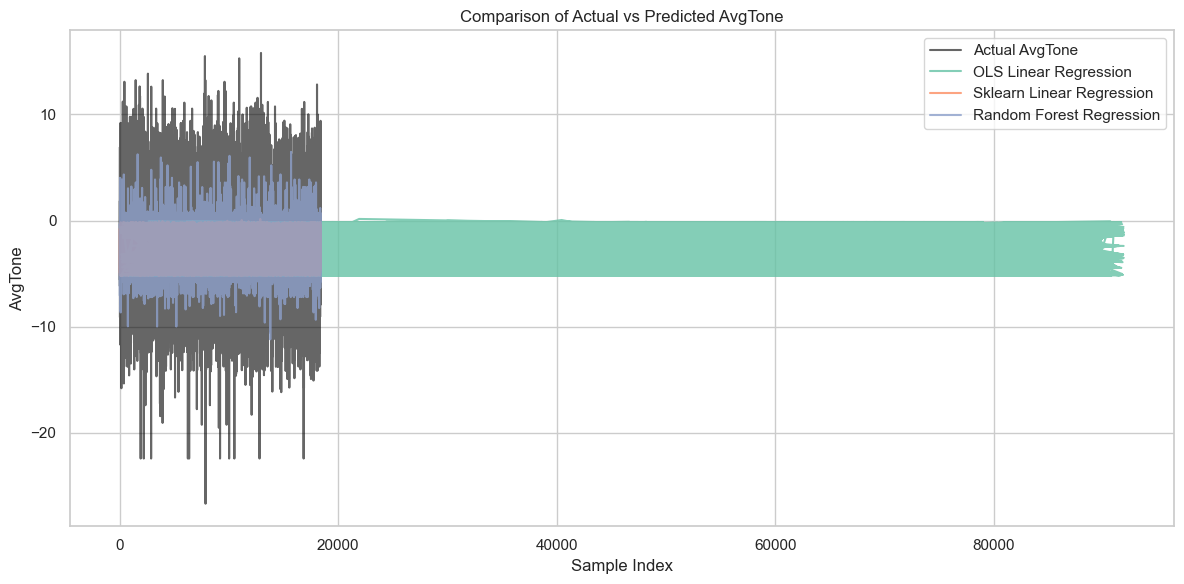

In [7]:
# ==================================================
# Cell 10: Visual Comparison of Predicted vs Actual AvgTone
# ==================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot actual AvgTone
plt.plot(y_test.values, label="Actual AvgTone", color="black", alpha=0.6)

# Plot predictions
plt.plot(y_pred_linear, label="OLS Linear Regression", alpha=0.8)
plt.plot(y_pred_lr, label="Sklearn Linear Regression", alpha=0.8)
plt.plot(y_pred_rf, label="Random Forest Regression", alpha=0.8)

plt.title("Comparison of Actual vs Predicted AvgTone")
plt.xlabel("Sample Index")
plt.ylabel("AvgTone")
plt.legend()
plt.tight_layout()
plt.show()


Top Features Influencing AvgTone (Random Forest):
          Feature  Importance
3  GoldsteinScale    0.743465
4       QuadClass    0.089990
0     NumMentions    0.075577
2     NumArticles    0.059847
1      NumSources    0.031120


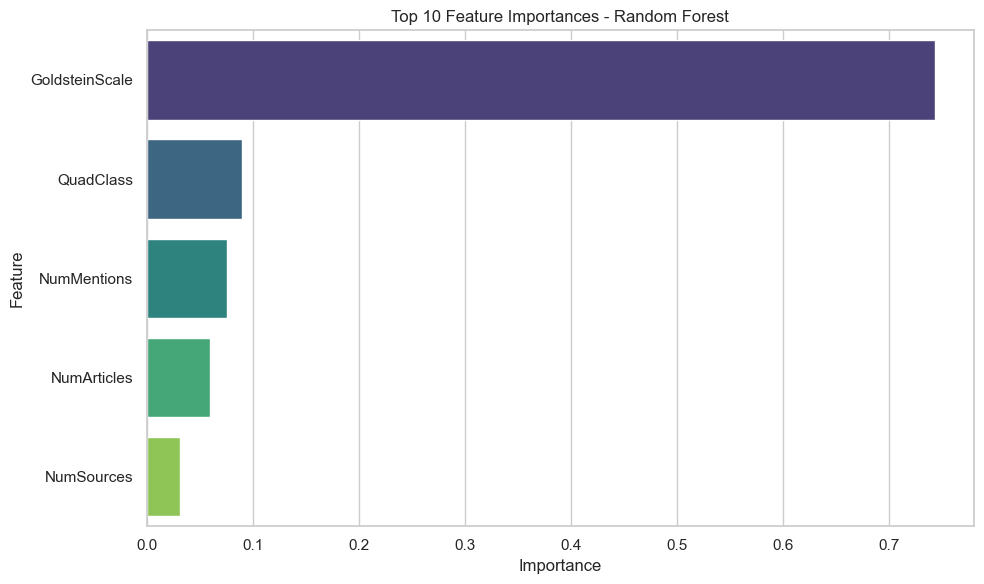

In [8]:
# ==================================================
# Cell 11: Feature Importance (Random Forest)
# ==================================================

importances = rf.feature_importances_
feature_names = X.columns

# Create a DataFrame for better visualization
feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Display top features
print("Top Features Influencing AvgTone (Random Forest):")
print(feat_imp_df.head(10))

# Plot feature importance
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feat_imp_df.head(10), hue="Feature", legend=False, palette="viridis")
plt.title("Top 10 Feature Importances - Random Forest")
plt.tight_layout()
plt.show()

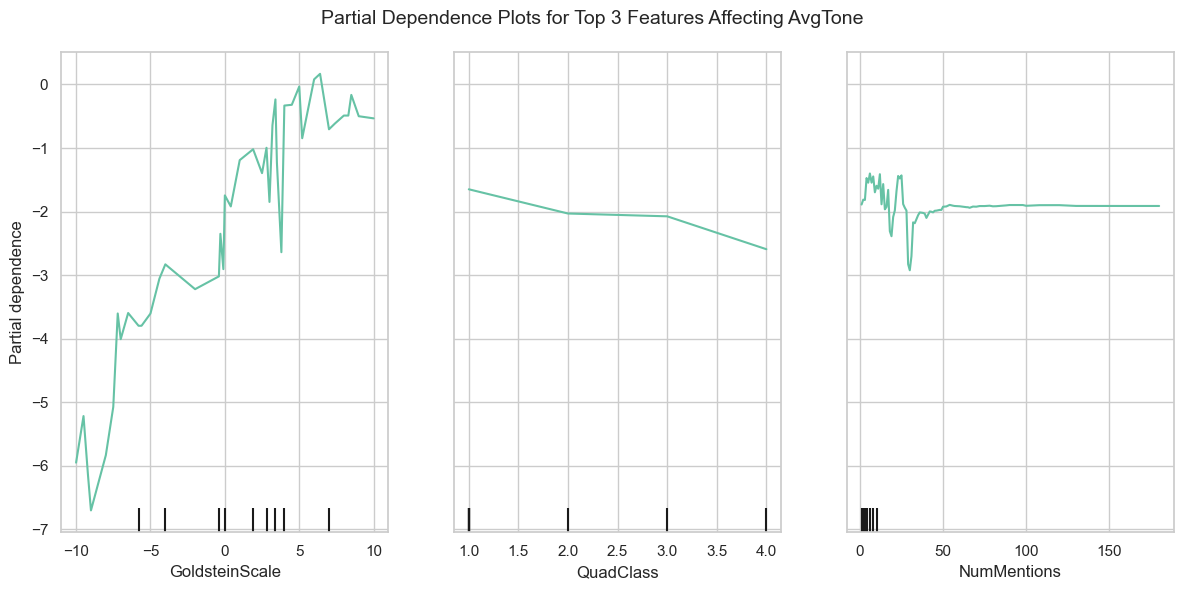

In [9]:
# ==================================================
# Cell 12: Partial Dependence Plots for Top Features
# ==================================================

from sklearn.inspection import partial_dependence, PartialDependenceDisplay

# Select top 3 features from feature importance
top_features = feat_imp_df["Feature"].head(3).tolist()

# Plot Partial Dependence
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(
    rf,
    X,
    features=top_features,
    kind="average",
    ax=ax
)
plt.suptitle("Partial Dependence Plots for Top 3 Features Affecting AvgTone", fontsize=14)
plt.tight_layout()
plt.show()

Random Forest Model Evaluation:
Mean Absolute Error (MAE): 2.8749
Root Mean Squared Error (RMSE): 3.7268


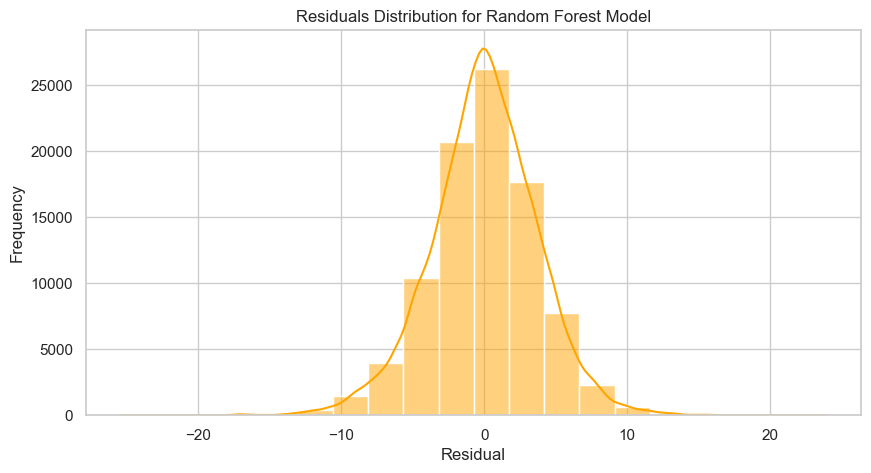

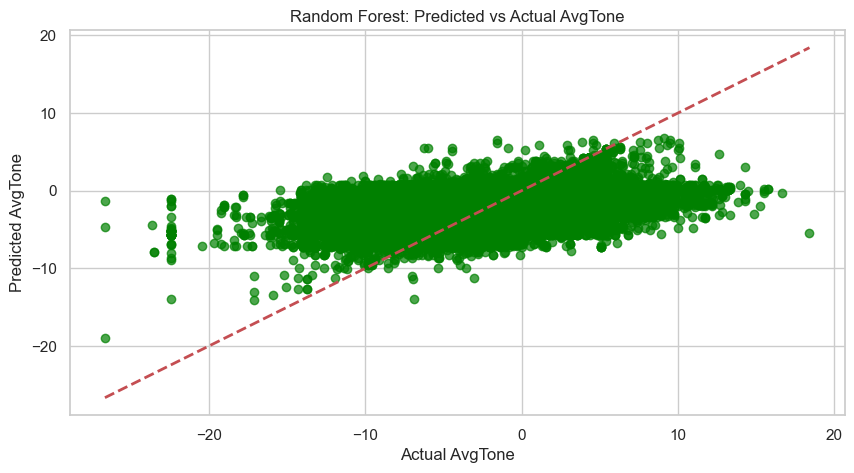

In [10]:
# ==================================================
# Cell 13: Model Evaluation & Residual Analysis
# ==================================================

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Predictions on the training data
y_pred = rf.predict(X)

# Compute evaluation metrics
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"Random Forest Model Evaluation:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Residuals
residuals = y - y_pred

# Plot residuals
plt.figure(figsize=(10,5))
sns.histplot(residuals, bins=20, kde=True, color="orange")
plt.title("Residuals Distribution for Random Forest Model")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# Scatter plot: Predicted vs Actual
plt.figure(figsize=(10,5))
plt.scatter(y, y_pred, alpha=0.7, color="green")
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--", linewidth=2)
plt.xlabel("Actual AvgTone")
plt.ylabel("Predicted AvgTone")
plt.title("Random Forest: Predicted vs Actual AvgTone")
plt.show()

In [11]:
# ==================================================
# Cell 14: Save Final Dataset & Feature Importances
# ==================================================

# Add predicted AvgTone to the original dataframe
df['Predicted_AvgTone'] = y_pred

# Save the dataframe to CSV
final_csv_path = "gdelt_events_with_predictions.csv"
df.to_csv(final_csv_path, index=False)
print(f"Final dataset with predictions saved to {final_csv_path}")

# Feature Importances from Random Forest
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display top 10 important features
top_features = feature_importances.head(10)
print("Top 10 Important Features for Predicting AvgTone:")
print(top_features)

# Save feature importances to CSV
feature_csv_path = "gdelt_feature_importances.csv"
feature_importances.to_csv(feature_csv_path, index=False)
print(f"Feature importances saved to {feature_csv_path}")

Final dataset with predictions saved to gdelt_events_with_predictions.csv
Top 10 Important Features for Predicting AvgTone:
          Feature  Importance
3  GoldsteinScale    0.743465
4       QuadClass    0.089990
0     NumMentions    0.075577
2     NumArticles    0.059847
1      NumSources    0.031120
Feature importances saved to gdelt_feature_importances.csv


C:\Users\kusha\AppData\Local\Temp\ipykernel_37528\724627191.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


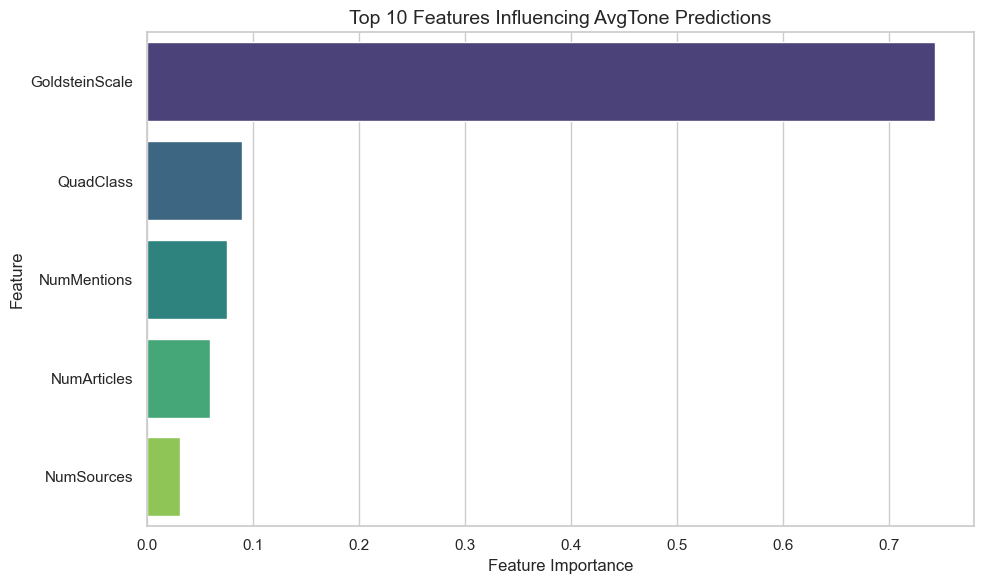

In [12]:
# ==================================================
# Cell 15: Visualize Top Feature Importances
# ==================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
sns.set(style="whitegrid")

# Plot top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=top_features,
    palette='viridis'
)
plt.title("Top 10 Features Influencing AvgTone Predictions", fontsize=14)
plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()


Mean Squared Error (MSE): 14.3215
R-squared (R²): 0.1502


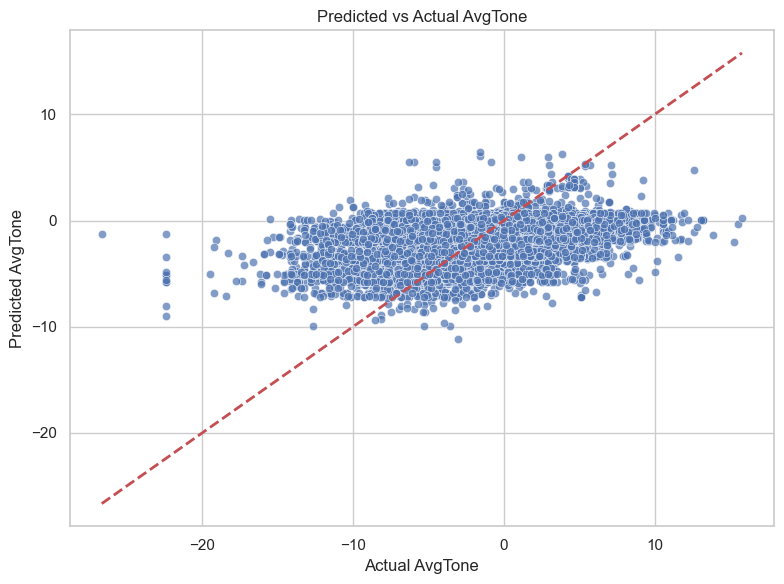

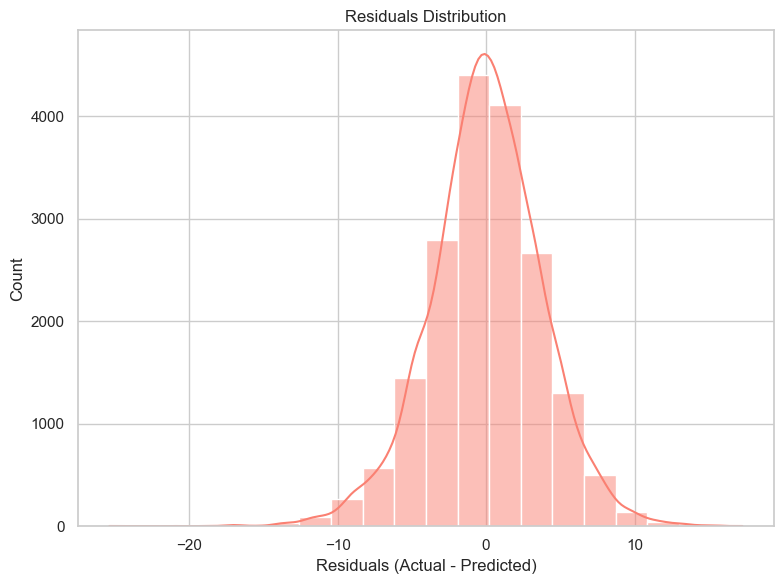

In [13]:
# ==================================================
# Cell 16: Evaluate Model Residuals & Plot Predictions
# ==================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# Predict using the trained Random Forest model
y_pred = rf.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Residuals
residuals = y_test - y_pred

# Plot Predicted vs Actual AvgTone
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual AvgTone")
plt.ylabel("Predicted AvgTone")
plt.title("Predicted vs Actual AvgTone")
plt.tight_layout()
plt.show()

# Plot residuals
plt.figure(figsize=(8,6))
sns.histplot(residuals, kde=True, color='salmon', bins=20)
plt.xlabel("Residuals (Actual - Predicted)")
plt.title("Residuals Distribution")
plt.tight_layout()
plt.show()

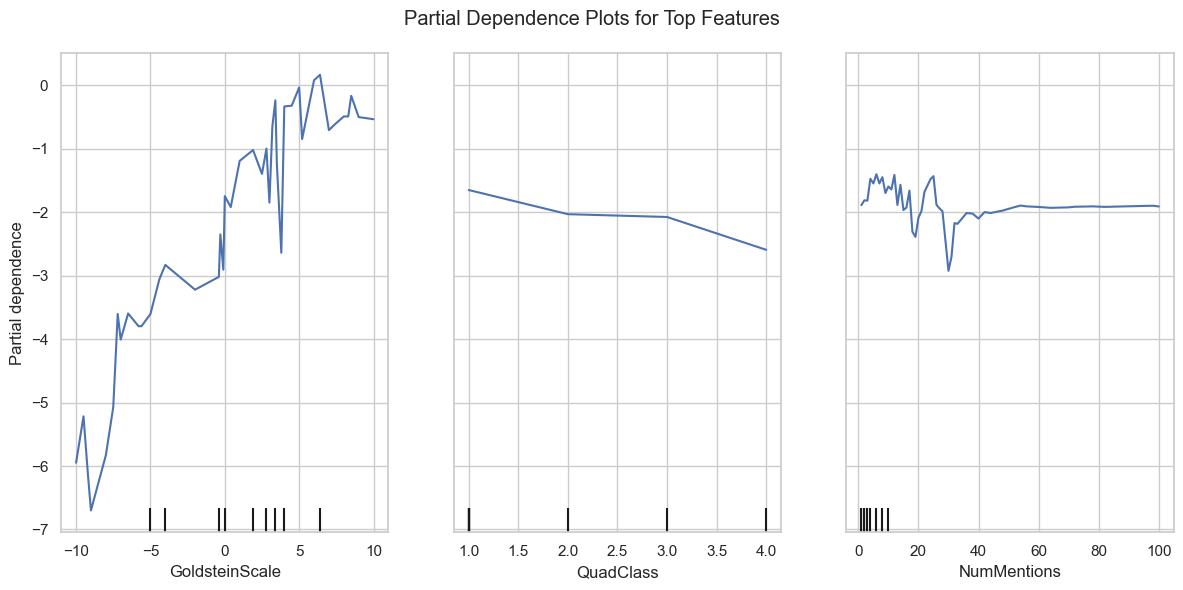

In [14]:
# ==================================================
# Cell 17: Partial Dependence Plots for Important Features
# ==================================================
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

# Select top 3 important features from the Random Forest model
top_features = feature_importances['Feature'].head(3).tolist() # Corrected: Extract only the feature names

# Create PDP plots
fig, ax = plt.subplots(figsize=(12, 6))
display = PartialDependenceDisplay.from_estimator(
    rf,
    X_test,
    features=top_features,
    kind="average",  # Average effect on prediction
    grid_resolution=50,
    ax=ax
)
plt.suptitle("Partial Dependence Plots for Top Features")
plt.tight_layout()
plt.show()